In [1]:
using MNIST
abstract Layer
abstract Optimizer
abstract Parameters

function loadMnistData()
  a,b = MNIST.traindata()
  t,l = MNIST.testdata()
  t = (t .- mean(t,2)) / std(t .- mean(t,2))
  a = (a .- mean(a,2)) / std(a .- mean(a,2))
  b = sparse(convert(Array{Int64}, b + 1),1:60000, [ 1 for i in 1:60000])
  l = sparse(convert(Array{Int64}, l + 1),1:10000, [ 1 for i in 1:10000])
  return(a,b,t,l)
end

function appendColumnOfOnes(a::Array{Float64,2})
  vcat(a,ones(1,size(a ,2)))
end

function exponentialNormalizer(params, input)
  log_nominator = input
  log_denominator = maximum(input,1) .+ log(sum(exp(input .- maximum(input,1)),1))
  return exp(log_nominator .- log_denominator)
end

# sigmoid  layer
function sigmoidNeuronTransformFunction(params, input)
  return 1.0 ./ (1.0 .+ exp(-params * appendColumnOfOnes(input)))
end

function sigmoidNeuronDerivativeFunction(input)
  return  input .* (1 - input)
end

function sigmoidComputingLayer()
  return (sigmoidNeuronTransformFunction, sigmoidNeuronDerivativeFunction)
end

# linear layer
function identityNeuronTransformFunction(params, input)
   return params * appendColumnOfOnes(input)
end

function identityNeuronDerivativeFunction(input)
  return  1
end

function linearComputingLayer()
  return (identityNeuronTransformFunction, identityNeuronDerivativeFunction)
end

# tanh layer
function tanhNeuronTransformFunction(params, input)
   x = params * appendColumnOfOnes(input)
   return tanh(x)
end

function tanhNeuronDerivativeFunction(input)
  return  1 .- input.^2
end

function tanhComputingLayer()
  return (tanhNeuronTransformFunction, tanhNeuronDerivativeFunction)
end

# ReLU layer
function reluNeuronTransformFunction(params, input)
   x = params * appendColumnOfOnes(input)
   return x .* (x .> 0)
end

function reluNeuronDerivativeFunction(input)
   return convert(Array{Float64,2}, input .> 0)
end

function reluComputingLayer()
  return (reluNeuronTransformFunction, reluNeuronDerivativeFunction)
end

# end of layers functions code

type FullyConnectedComputingLayer <: Layer
  inputSize::Int64
  numberOfNeurons::Int64
  parameters::Array{Float64,2}
  transform::Function
  derivative::Function # derivative added here

  function FullyConnectedComputingLayer(inputSize, numberOfNeurons, transform::Function, derivative::Function)
    parameters = randn(numberOfNeurons, inputSize + 1)  * 0.1 # adding one param column for bias
    return new(inputSize, numberOfNeurons, parameters, transform, derivative)
  end
end

type SoftMaxLayer <: Layer
  numberOfNeurons::Int64
  parameters::Any
  transform::Function

  function SoftMaxLayer(numberOfNeurons)
    return new(numberOfNeurons, [], exponentialNormalizer)
  end
end

type NetworkArchitecture
  layers::Array{Layer}
  function NetworkArchitecture(firstLayer::Layer)
    return new([firstLayer])
  end
end

function addSoftMaxLayer(architecture::NetworkArchitecture)
 lastNetworkLayer = architecture.layers[end]
 numberOfNeurons = lastNetworkLayer.numberOfNeurons
 softMaxLayer = SoftMaxLayer(numberOfNeurons)
 push!(architecture.layers, softMaxLayer)
end

function infer(architecture::NetworkArchitecture, input)
  currentResult = input
  for i in 1:length(architecture.layers)
     layer = architecture.layers[i]
     currentResult = layer.transform(layer.parameters, currentResult)
  end
  return currentResult
end

function crossEntropyError(architecture::NetworkArchitecture, input, labels)
 probabilitiesSparseMatrix = infer(architecture, input) .* labels
 probabilities = sum(probabilitiesSparseMatrix , 1)
 return -mean(log(probabilities))
end

type BackPropagationBatchLearningUnit
  networkArchitecture::NetworkArchitecture
  dataBatch::Array{Float64,2}
  labels::AbstractSparseMatrix
  outputs::Array{Array{Float64,2}} # outputs remembered now
  deltas::Array{Array{Float64,2}} # deltas kept here

  function BackPropagationBatchLearningUnit(arch::NetworkArchitecture, dataBatch::Array{Float64,2}, labels::AbstractSparseMatrix)
     outputs = [ zeros(l.numberOfNeurons, size(dataBatch,2)) for l in arch.layers ]
     deltas = [ zeros(l.numberOfNeurons, size(dataBatch,2)) for l in arch.layers ]
     return new(arch, dataBatch, labels, outputs, deltas)
  end
end

function forwardPass!(learningUnit::BackPropagationBatchLearningUnit)
  currentResult = learningUnit.dataBatch
  for i in 1:length(learningUnit.networkArchitecture.layers)
     layer = learningUnit.networkArchitecture.layers[i]
     currentResult = layer.transform(layer.parameters, currentResult)
     learningUnit.outputs[i]  = currentResult
  end
end

function backwardPass!(learningUnit::BackPropagationBatchLearningUnit)

  layer = learningUnit.networkArchitecture.layers[end-1]
  learningUnit.deltas[end-1]  = layer.derivative(learningUnit.outputs[end-1]) .*  (learningUnit.outputs[end] - learningUnit.labels)

  for i in 2:(length(learningUnit.networkArchitecture.layers) - 1)
      higherLayer = learningUnit.networkArchitecture.layers[end - i + 1]
      currentLayer = learningUnit.networkArchitecture.layers[end - i]
      learningUnit.deltas[end-i] = currentLayer.derivative(learningUnit.outputs[end-i]) .* (transpose(higherLayer.parameters[:,(1:end-1)]) * learningUnit.deltas[end - i + 1])
  end
end

#--------------------------------------------------------------#
# Stochastic Gradient Descent Optimizer

type SGDParameters <: Parameters
  learningRate::Float64
end

type SGDOptimizer <: Optimizer
  params::Parameters
  updateRule!::Function
  function SGDOptimizer(learningRate::Float64)
    return new(SGDParameters(learningRate), sgdUpdateFunction)
  end
end

function sgdUpdateFunction(unit::BackPropagationBatchLearningUnit, params::Parameters)
  forwardPass!(unit)
  backwardPass!(unit)
  derivativeW = (unit.deltas[1] * transpose(unit.dataBatch)) / size(unit.dataBatch,2);
  derivativeB = mean(unit.deltas[1],2)
  unit.networkArchitecture.layers[1].parameters[:,1:(end-1)] = unit.networkArchitecture.layers[1].parameters[:,1:(end-1)] - params.learningRate * derivativeW
  unit.networkArchitecture.layers[1].parameters[:,end] =  unit.networkArchitecture.layers[1].parameters[:,end] - params.learningRate * derivativeB
  for i in 2:(length(unit.networkArchitecture.layers) - 1)
    derivativeW = (unit.deltas[i] * transpose(unit.outputs[i-1])) / size(unit.dataBatch,2);
    derivativeB = mean(unit.deltas[i],2);
    unit.networkArchitecture.layers[i].parameters[:,1:(end-1)] = unit.networkArchitecture.layers[i].parameters[:,1:(end-1)] - params.learningRate * derivativeW
    unit.networkArchitecture.layers[i].parameters[:,end] = unit.networkArchitecture.layers[i].parameters[:,end] - params.learningRate *  derivativeB
  end
end

#--------------------------------------------------------------#
# Stochastic Gradient Descent (+ Momentum) Optimizer

type MomentumParameters <: Parameters
  learningRate::Float64
  gamma::Float64
  velocity::Array{Array{Float64,2}}
end

type MomentumOptimizer <: Optimizer
  params::Parameters
  updateRule!::Function

  function MomentumOptimizer(learningRate::Float64, gamma::Float64, architecture::NetworkArchitecture)
    velocity = [ zeros(size(x.parameters)) for x in architecture.layers[1:end-1] ]
    return new(MomentumParameters(learningRate, gamma, velocity), momentumUpdateFunction!)
  end
end

function momentumUpdateFunction!(unit::BackPropagationBatchLearningUnit, params::Parameters)
  forwardPass!(unit)
  backwardPass!(unit)
  derivativeW = (unit.deltas[1] * transpose(unit.dataBatch)) / size(unit.dataBatch,2);
  derivativeB = mean(unit.deltas[1],2)
  params.velocity[1][:,1:(end-1)] = params.gamma * params.velocity[1][:,1:(end-1)] +  derivativeW
  params.velocity[1][:,end] = params.gamma * params.velocity[1][:,end] + derivativeB
  unit.networkArchitecture.layers[1].parameters[:,1:(end-1)] = unit.networkArchitecture.layers[1].parameters[:,1:(end-1)] -  params.learningRate *  params.velocity[1][:,1:(end-1)]
  unit.networkArchitecture.layers[1].parameters[:,end] =  unit.networkArchitecture.layers[1].parameters[:,end] -  params.learningRate * params.velocity[1][:,end]
  for i in 2:(length(unit.networkArchitecture.layers) - 1)
    derivativeW = (unit.deltas[i] * transpose(unit.outputs[i-1])) / size(unit.dataBatch,2);
    derivativeB = mean(unit.deltas[i],2);
    params.velocity[i][:,1:(end-1)] = params.gamma * params.velocity[i][:,1:(end-1)] +  derivativeW
    params.velocity[i][:,end] = params.gamma * params.velocity[i][:,end] + derivativeB
    unit.networkArchitecture.layers[i].parameters[:,1:(end-1)] = unit.networkArchitecture.layers[i].parameters[:,1:(end-1)] - params.learningRate * params.velocity[i][:,1:(end-1)]
    unit.networkArchitecture.layers[i].parameters[:,end] = unit.networkArchitecture.layers[i].parameters[:,end] - params.learningRate * params.velocity[i][:,end]
  end
end

#--------------------------------------------------------------#
# Adagrad Optimizer

type AdaGradParameters <: Parameters
  learningRate::Float64
  G::Array{Array{Float64,2}}
end

type AdaGradOptimizer <: Optimizer
  params::Parameters
  updateRule!::Function

  function AdaGradOptimizer(learningRate::Float64, architecture::NetworkArchitecture)
    G = [ zeros(size(x.parameters)) for x in architecture.layers[1:end-1] ]
    return new(AdaGradParameters(learningRate, G), adagradUpdateFunction!)
  end
end

function adagradUpdateFunction!(unit::BackPropagationBatchLearningUnit, params::Parameters)
  forwardPass!(unit)
  backwardPass!(unit)
  derivativeW = (unit.deltas[1] * transpose(unit.dataBatch)) / size(unit.dataBatch,2);
  derivativeB = mean(unit.deltas[1],2)
  params.G[1][:,1:(end-1)] = params.G[1][:,1:(end-1)] +  (derivativeW.^2)
  params.G[1][:,end] = params.G[1][:,end] + (derivativeB.^2)
  unit.networkArchitecture.layers[1].parameters[:,1:(end-1)] = unit.networkArchitecture.layers[1].parameters[:,1:(end-1)] - (params.learningRate ./ ( 1e-6 + sqrt(params.G[1][:,1:(end-1)]))).* derivativeW
  unit.networkArchitecture.layers[1].parameters[:,end] =  unit.networkArchitecture.layers[1].parameters[:,end]- (params.learningRate ./ ( 1e-6 + sqrt(params.G[1][:,end]))).* derivativeB
  for i in 2:(length(unit.networkArchitecture.layers) - 1)
    derivativeW = (unit.deltas[i] * transpose(unit.outputs[i-1])) / size(unit.dataBatch,2);
    derivativeB = mean(unit.deltas[i],2);
    params.G[i][:,1:(end-1)] = params.G[i][:,1:(end-1)] +  (derivativeW.^2)
    params.G[i][:,end] = params.G[i][:,end] + (derivativeB.^2)
    unit.networkArchitecture.layers[i].parameters[:,1:(end-1)] = unit.networkArchitecture.layers[i].parameters[:,1:(end-1)] - (params.learningRate ./ ( 1e-6 + sqrt(params.G[i][:,1:(end-1)]))) .* derivativeW
    unit.networkArchitecture.layers[i].parameters[:,end] =  unit.networkArchitecture.layers[i].parameters[:,end] -  (params.learningRate ./( 1e-6 + sqrt(params.G[i][:,end]))) .* derivativeB
  end
end

#--------------------------------------------------------------#
# AdaDelta Optimizer

type AdaDeltaParameters <: Parameters
  rho::Float64
  EG::Array{Array{Float64,2}}
  EDeltaX::Array{Array{Float64,2}}
end

type AdaDeltaOptimizer <: Optimizer
  params::Parameters
  updateRule!::Function

  function AdaDeltaOptimizer(rho::Float64, architecture::NetworkArchitecture)
    EG = [ zeros(size(x.parameters)) for x in architecture.layers[1:end-1] ]
    EDeltaX = [ zeros(size(x.parameters)) for x in architecture.layers[1:end-1] ]
    return new(AdaDeltaParameters(rho, EG, EDeltaX), adadeltaUpdateFunction!)
  end
end

function adadeltaUpdateFunction!(unit::BackPropagationBatchLearningUnit, params::Parameters)
  forwardPass!(unit)
  backwardPass!(unit)
  derivativeW = (unit.deltas[1] * transpose(unit.dataBatch)) / size(unit.dataBatch,2);
  derivativeB = mean(unit.deltas[1],2)
  params.EG[1][:,1:(end-1)] = params.rho * params.EG[1][:,1:(end-1)] +  (1-params.rho) * (derivativeW.^2)
  params.EG[1][:,end] = params.rho * params.EG[1][:,end] + (1-params.rho) * (derivativeB.^2)
  updateW = - ((sqrt(params.EDeltaX[1][:,1:(end-1)] + 1e-6)) ./ (sqrt(params.EG[1][:,1:(end-1)] + 1e-6))) .* derivativeW;
  updateB = - ((sqrt(params.EDeltaX[1][:,end] + 1e-6)) ./ (sqrt(params.EG[1][:,end] + 1e-6))) .* derivativeB;
  unit.networkArchitecture.layers[1].parameters[:,1:(end-1)] = unit.networkArchitecture.layers[1].parameters[:,1:(end-1)] + updateW;
  unit.networkArchitecture.layers[1].parameters[:,end] =  unit.networkArchitecture.layers[1].parameters[:,end] + updateB;
  params.EDeltaX[1][:,1:(end-1)] = params.rho * params.EDeltaX[1][:,1:(end-1)] +  (1-params.rho) * (updateW.^2)
  params.EDeltaX[1][:,end] = params.rho * params.EDeltaX[1][:,end] + (1-params.rho) * (updateB.^2)

  for i in 2:(length(unit.networkArchitecture.layers) - 1)
    derivativeW = (unit.deltas[i] * transpose(unit.outputs[i-1])) / size(unit.dataBatch,2);
    derivativeB = mean(unit.deltas[i],2);
    params.EG[i][:,1:(end-1)] = params.rho * params.EG[i][:,1:(end-1)] +  (1-params.rho) * (derivativeW.^2)
    params.EG[i][:,end] = params.rho * params.EG[i][:,end] + (1-params.rho) * (derivativeB.^2)
    updateW = - ((sqrt(params.EDeltaX[i][:,1:(end-1)] + 1e-6)) ./ (sqrt(params.EG[i][:,1:(end-1)] + 1e-6))) .* derivativeW;
    updateB = - ((sqrt(params.EDeltaX[i][:,end] + 1e-6)) ./ (sqrt(params.EG[i][:,end] + 1e-6))) .* derivativeB;
    unit.networkArchitecture.layers[i].parameters[:,1:(end-1)] = unit.networkArchitecture.layers[i].parameters[:,1:(end-1)] + updateW;
    unit.networkArchitecture.layers[i].parameters[:,end] =  unit.networkArchitecture.layers[i].parameters[:,end] + updateB;
    params.EDeltaX[i][:,1:(end-1)] = params.rho * params.EDeltaX[i][:,1:(end-1)] +  (1-params.rho) * (updateW.^2)
    params.EDeltaX[i][:,end] = params.rho * params.EDeltaX[i][:,end] + (1-params.rho) * (updateB.^2)
  end
end

type AdamParameters <: Parameters
  i::Int64
  alpha::Float64
  beta1::Float64
  beta2::Float64
  M::Array{Array{Float64,2}}
  V::Array{Array{Float64,2}}
end

type AdamOptimizer <: Optimizer
  params::Parameters
  updateRule!::Function

  function AdamOptimizer(i::Int64, alpha::Float64, beta1::Float64, beta2::Float64, architecture::NetworkArchitecture)
    M = [ zeros(size(x.parameters)) for x in architecture.layers[1:end-1] ]
    V = [ zeros(size(x.parameters)) for x in architecture.layers[1:end-1] ]
    return new(AdamParameters(i, alpha, beta1, beta2, M, V), adamUpdateFunction!)
  end
end

function adamUpdateFunction!(unit::BackPropagationBatchLearningUnit, params::Parameters)
  forwardPass!(unit)
  backwardPass!(unit)
  params.i += 1
  derivativeW = (unit.deltas[1] * transpose(unit.dataBatch)) / size(unit.dataBatch,2);
  derivativeB = mean(unit.deltas[1],2)
  params.M[1][:,1:(end-1)] = params.beta1 * params.M[1][:,1:(end-1)] +  (1-params.beta1) * (derivativeW)
  params.M[1][:,end] = params.beta1 * params.M[1][:,end] + (1-params.beta1) * (derivativeB)
  params.V[1][:,1:(end-1)] = params.beta2 * params.V[1][:,1:(end-1)] +  (1-params.beta2) * (derivativeW.^2)
  params.V[1][:,end] = params.beta2 * params.V[1][:,end] + (1-params.beta2) * (derivativeB.^2)
  updateW = -((params.M[1][:,1:(end-1)]) ./ (1-params.beta1)) ./ (sqrt(params.V[1][:,1:(end-1)] ./ (1-params.beta2)) + 1e-8)
  updateB = -((params.M[1][:,end]) ./ (1-params.beta1)) ./ (sqrt(params.V[1][:,end] ./ (1-params.beta2)) + 1e-8)
  unit.networkArchitecture.layers[1].parameters[:,1:(end-1)] = unit.networkArchitecture.layers[1].parameters[:,1:(end-1)] + params.alpha * updateW;
  unit.networkArchitecture.layers[1].parameters[:,end] =  unit.networkArchitecture.layers[1].parameters[:,end] + params.alpha * updateB;

  for i in 2:(length(unit.networkArchitecture.layers) - 1)
    derivativeW = (unit.deltas[i] * transpose(unit.outputs[i-1])) / size(unit.dataBatch,2);
    derivativeB = mean(unit.deltas[i],2);
    params.M[i][:,1:(end-1)] = params.beta1 * params.M[i][:,1:(end-1)] +  (1-params.beta1) * (derivativeW)
    params.M[i][:,end] = params.beta1 * params.M[i][:,end] + (1-params.beta1) * (derivativeB)
    params.V[i][:,1:(end-1)] = params.beta2 * params.V[i][:,1:(end-1)] +  (1-params.beta2) * (derivativeW.^2)
    params.V[i][:,end] = params.beta2 * params.V[i][:,end] + (1-params.beta2) * (derivativeB.^2)
    updateW = -((params.M[i][:,1:(end-1)]) ./ (1-params.beta1^params.i)) ./ (sqrt(params.V[i][:,1:(end-1)] ./ (1-params.beta2^params.i)) + 1e-8)
    updateB = -((params.M[i][:,end]) ./ (1-params.beta1^params.i)) ./ (sqrt(params.V[i][:,end] ./ (1-params.beta2^params.i)) + 1e-8)
    unit.networkArchitecture.layers[i].parameters[:,1:(end-1)] = unit.networkArchitecture.layers[i].parameters[:,1:(end-1)] + params.alpha *  updateW;
    unit.networkArchitecture.layers[i].parameters[:,end] =  unit.networkArchitecture.layers[i].parameters[:,end] + params.alpha * updateB;
  end
end

# function addFullyConnectedLayer(architecture::NetworkArchitecture, numberOfNeurons::Int64, functionsPair::(Function,Function))
function addFullyConnectedLayer(architecture::NetworkArchitecture, numberOfNeurons::Int64, functionsPair1::Function, functionsPair2::Function,)
 lastNetworkLayer = architecture.layers[end]
 inputSize = lastNetworkLayer.numberOfNeurons
 layer = FullyConnectedComputingLayer(inputSize, numberOfNeurons, functionsPair1, functionsPair2)
 push!(architecture.layers, layer)
end

function buildNetworkArchitecture(inputSize, layersSizes, layersFunctions::Array{Function, 1})
  firstLayer = FullyConnectedComputingLayer(inputSize, layersSizes[1], layersFunctions[1]()[1], layersFunctions[1]()[2]);
  architecture = NetworkArchitecture(firstLayer);
  for i in 2:(length(layersSizes))
        addFullyConnectedLayer(architecture, layersSizes[i], layersFunctions[i]()[1],layersFunctions[i]()[2]);
  end
  addSoftMaxLayer(architecture)
  return(architecture)
end


buildNetworkArchitecture (generic function with 1 method)

In [2]:
trainingData, trainingLabels, testData, testLabels = loadMnistData()
architecture = buildNetworkArchitecture(784, [50, 10], [sigmoidComputingLayer, linearComputingLayer])
adam = AdamOptimizer(0, 0.002, 0.9, .999, architecture)
crossEntropiesAdam = Float64[]
batchSize = 128
for i = 1:40000
   minibatch = collect((batchSize*i):(batchSize*i +batchSize)) % size(trainingLabels,2) + 1 # take next 20 elements
   learningUnit = BackPropagationBatchLearningUnit(architecture, trainingData[:,minibatch ],
                                                   trainingLabels[:,minibatch]);
   adam.updateRule!(learningUnit, adam.params)
   if i % 100 == 0  # this one costs so lets store entropies every 100 iterations
     push!(crossEntropiesAdam, crossEntropyError(architecture, trainingData, trainingLabels))
   end
end

In [3]:
architecture = buildNetworkArchitecture(784, [50,10], [sigmoidComputingLayer, linearComputingLayer])
momentum = MomentumOptimizer(0.05, 0.9, architecture)
crossEntropiesMomentum = Float64[]
batchSize = 128
for i = 1:40000
   minibatch = collect((batchSize*i):(batchSize*i +batchSize)) % size(trainingLabels,2) + 1 # take next 20 elements
   learningUnit = BackPropagationBatchLearningUnit(architecture, trainingData[:,minibatch ],
                                                  trainingLabels[:,minibatch]);
   momentum.updateRule!(learningUnit, momentum.params)
   if i % 100 == 0  # this one costs so lets store entropies every 100 iterations
     push!(crossEntropiesMomentum, crossEntropyError(architecture, trainingData, trainingLabels))
   end
end

In [4]:
architecture = buildNetworkArchitecture(784, [50,10], [sigmoidComputingLayer, linearComputingLayer])
AdaGrad = AdaGradOptimizer(0.05, architecture)
crossEntropiesAdaGrad = Float64[]
batchSize = 128
for i = 1:40000
   minibatch = collect((batchSize*i):(batchSize*i +batchSize)) % size(trainingLabels,2) + 1 # take next 20 elements
   learningUnit = BackPropagationBatchLearningUnit(architecture, trainingData[:,minibatch ],
                                                  trainingLabels[:,minibatch]);
   AdaGrad.updateRule!(learningUnit, AdaGrad.params)
   if i % 100 == 0  # this one costs so lets store entropies every 100 iterations
     push!(crossEntropiesAdaGrad, crossEntropyError(architecture, trainingData, trainingLabels))
   end
end

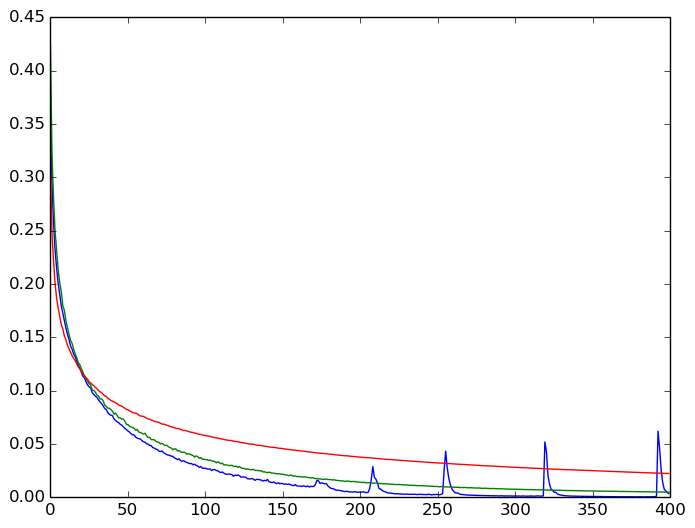

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f06de7c2fd0>

In [5]:
using PyPlot
plot(crossEntropiesAdam,color="blue")
plot(crossEntropiesMomentum,color="green")
plot(crossEntropiesAdaGrad,color="red")

In [ ]:
trainingData, trainingLabels, testData, testLabels = loadMnistData()
architecture = buildNetworkArchitecture(784, [50, 10], [reluComputingLayer,linearComputingLayer])
adam = AdamOptimizer(0, 0.002, 0.9, .999, architecture)
crossEntropiesAdam = Float64[]
batchSize = 128
for i = 1:40000
   minibatch = collect((batchSize*i):(batchSize*i +batchSize)) % size(trainingLabels,2) + 1 # take next 20 elements
   learningUnit = BackPropagationBatchLearningUnit(architecture, trainingData[:,minibatch ],
                                                   trainingLabels[:,minibatch]);
   adam.updateRule!(learningUnit, adam.params)
   if i % 100 == 0  # this one costs so lets store entropies every 100 iterations
     push!(crossEntropiesAdam, crossEntropyError(architecture, trainingData, trainingLabels))
   end
end

In [ ]:
architecture = buildNetworkArchitecture(784, [50,10], [reluComputingLayer, linearComputingLayer])
momentum = MomentumOptimizer(0.05, 0.9, architecture)
crossEntropiesMomentum = Float64[]
batchSize = 128
for i = 1:40000
   minibatch = collect((batchSize*i):(batchSize*i +batchSize)) % size(trainingLabels,2) + 1 # take next 20 elements
   learningUnit = BackPropagationBatchLearningUnit(architecture, trainingData[:,minibatch ],
                                                  trainingLabels[:,minibatch]);
   momentum.updateRule!(learningUnit, momentum.params)
   if i % 100 == 0  # this one costs so lets store entropies every 100 iterations
     push!(crossEntropiesMomentum, crossEntropyError(architecture, trainingData, trainingLabels))
   end
end

In [ ]:
architecture = buildNetworkArchitecture(784, [50,10], [reluComputingLayer, linearComputingLayer])
AdaGrad = AdaGradOptimizer(0.05, architecture)
crossEntropiesAdaGrad = Float64[]
batchSize = 128
for i = 1:40000
   minibatch = collect((batchSize*i):(batchSize*i +batchSize)) % size(trainingLabels,2) + 1 # take next 20 elements
   learningUnit = BackPropagationBatchLearningUnit(architecture, trainingData[:,minibatch ],
                                                  trainingLabels[:,minibatch]);
   AdaGrad.updateRule!(learningUnit, AdaGrad.params)
   if i % 100 == 0  # this one costs so lets store entropies every 100 iterations
     push!(crossEntropiesAdaGrad, crossEntropyError(architecture, trainingData, trainingLabels))
   end
end

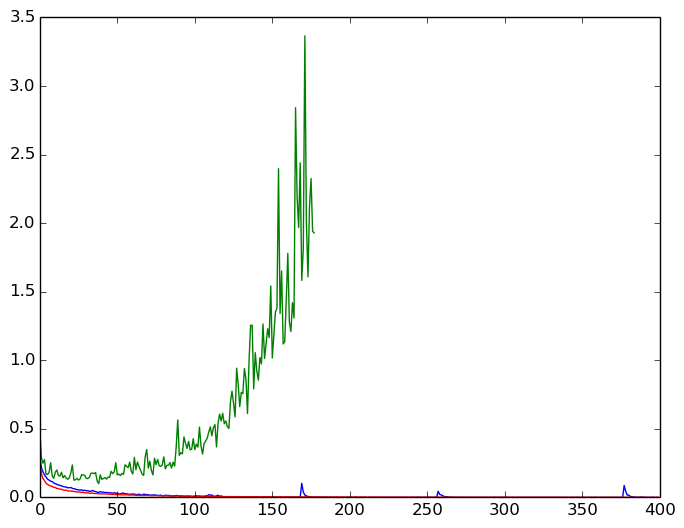

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f06de5b3790>

In [10]:
plot(crossEntropiesAdam,color="blue")
plot(crossEntropiesMomentum,color="green")
plot(crossEntropiesAdaGrad,color="red")

In [4]:
trainingLabels

10×60000 sparse matrix with 60000 Int64 nonzero entries:
	[6    ,     1]  =  1
	[1    ,     2]  =  1
	[5    ,     3]  =  1
	[2    ,     4]  =  1
	[10   ,     5]  =  1
	[3    ,     6]  =  1
	[2    ,     7]  =  1
	[4    ,     8]  =  1
	[2    ,     9]  =  1
	[5    ,    10]  =  1
	⋮
	[9    , 59990]  =  1
	[10   , 59991]  =  1
	[3    , 59992]  =  1
	[10   , 59993]  =  1
	[6    , 59994]  =  1
	[2    , 59995]  =  1
	[9    , 59996]  =  1
	[4    , 59997]  =  1
	[6    , 59998]  =  1
	[7    , 59999]  =  1
	[9    , 60000]  =  1